# Pre-processing of avalanche warning data for machine learning


In [1]:
import pandas as pd
import numpy as np
import json
#import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style="white")
#from sklearn import tree
#from sklearn.preprocessing import LabelEncoder
#from pprint import pprint

#pd.set_option("display.max_rows",6)

%matplotlib inline

In [3]:
# analysis of entire data set
varsom_df = pd.read_csv(r'..\..\data\varsom\norwegian_avalanche_warnings_season_17_18.csv', index_col=0)
varsom_df.head()

,author,avalanche_danger,avalanche_problem_1_advice,avalanche_problem_1_cause_id,avalanche_problem_1_cause_name,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_destructive_size_ext_name,avalanche_problem_1_distribution_id,avalanche_problem_1_distribution_name,avalanche_problem_1_exposed_height_1,...,region_id,region_name,region_type_id,region_type_name,snow_surface,utm_east,utm_north,utm_zone,valid_from,valid_to
index,,,,,,,,,,,,,,,,,,,,,
0,Karsten@NVE,Det er lite snø og generelt stabile forhold i ...,Vær varsom der skredproblemet er å finne i ko...,15,Dårlig binding mellom lag i fokksnøen,2,2 - Middels,1,Få bratte heng,0,...,3003,Nordenskiöld Land,10,A,Det er generelt lite snø i terrenget. Rygger e...,520332,8663904,33,2017-12-01 00:00:00,2017-12-01 23:59:59
1,jan arild@obskorps,Kraftig vind fra sørøst vil gi pålagring av fe...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3007,Vest-Finnmark,10,A,Siste dagene har det kommet 25-30 cm snø utsat...,802123,7794717,33,2017-12-01 00:00:00,2017-12-01 23:59:59
2,jan arild@obskorps,"Generelle stabile forhold, men vindøkning fra ...",Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3009,Nord-Troms,10,A,Siste dagene har det kommet 20-30 cm snø utsat...,750984,7742562,33,2017-12-01 00:00:00,2017-12-01 23:59:59
3,jan arild@obskorps,Vindøkning fra sør vil gi pålagring av fersk f...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3010,Lyngen,10,A,Siste dagene har det kommet 10-20 cm snø utsat...,692056,7719872,33,2017-12-01 00:00:00,2017-12-01 23:59:59
4,jan arild@obskorps,Kraftig vind fra sør vil gi pålagring av fersk...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3011,Tromsø,10,A,Siste dagene har det kommet 25-40 cm snø utsat...,656496,7764237,33,2017-12-01 00:00:00,2017-12-01 23:59:59


Check if there are missing values. Eventually remove variables with many missing values.

In [10]:
# Find the amount of NaN values in each column
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_change_wind_direction           2509
mountain_weather_change_hour_of_day_start        2491
mountain_weather_change_hour_of_day_stop         2491
mountain_weather_change_wind_speed               2483
mountain_weather_fl_hour_of_day_stop             1543
mountain_weather_fl_hour_of_day_start            1543
latest_observations                              1161
latest_avalanche_activity                         821
mountain_weather_freezing_level                   417
current_weak_layers                               247
mountain_weather_wind_direction                    74
mountain_weather_temperature_max                   45
mountain_weather_temperature_min                   44
mountain_weather_temperature_elevation             30
mountain_weather_precip_most_exposed                6
mountain_weather_precip_region                      4
avalanche_problem_2_advice                          2
avalanche_problem_1_advice                          2
mountain_weather_wind_speed 

In [11]:
varsom_df.pop('mountain_weather_change_wind_direction')
varsom_df.pop('mountain_weather_change_hour_of_day_start')
varsom_df.pop('mountain_weather_change_hour_of_day_stop')
varsom_df.pop('mountain_weather_change_wind_speed')
varsom_df.pop('mountain_weather_fl_hour_of_day_stop')
varsom_df.pop('mountain_weather_fl_hour_of_day_start')
varsom_df.pop('latest_observations')

index
0                                                     NaN
1                                                     NaN
2       Drønn og skytende sprekker i snødekket ble obs...
3       En del drønn er observert i snødekket de siste...
4       Skytende sprekker og drønn i snøen er observer...
5       Det er observert en del drønn i snødekket unde...
6       Observatør melder om en del sprekker og utgldn...
7       Observatør melder om en del sprekker og utgldn...
8                                                     NaN
9                                                     NaN
10      Det ble observert drønn og skytende sprekker u...
11      Snøgrensa ligger på ca. 200 moh i regionen. \r...
12      Torsdag formiddag var det Mannen målestasjon (...
13      Det ligger nå litt over en meter snø i fjellet...
14      Det ligger nå litt over en meter snø i fjellet...
15                                                    NaN
16      Det ligger nå litt over en meter snø i fjellet...
17      

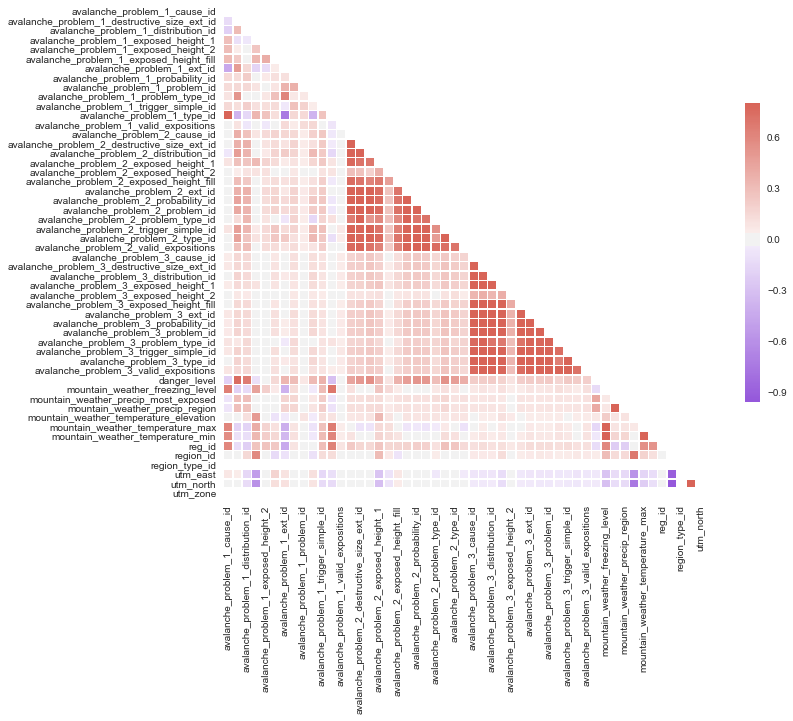

In [14]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can see that someparameters are correlated - correlation coefficient is high between them, so we can remove some of them. These are mainly \_name and \_id of the same variable.

Remove using _df.pop()_

In [20]:
# Compute the correlation matrix - works only on numerical variables.

#corr = varsom_df.corr()
#corr['avalanche_problem_1_cause_id'].sort_values(ascending=False)
#corr

Create a new dataframe with only the numerical variables

In [21]:
varsom_num = varsom_df.copy()

In [22]:
#sns.pairplot(varsom_df)

In [23]:
# let's see the details about remainig variables 

varsom_df.describe()

,avalanche_problem_1_cause_id,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_distribution_id,avalanche_problem_1_exposed_height_1,avalanche_problem_1_exposed_height_2,avalanche_problem_1_exposed_height_fill,avalanche_problem_1_ext_id,avalanche_problem_1_probability_id,avalanche_problem_1_problem_id,avalanche_problem_1_problem_type_id,...,mountain_weather_precip_region,mountain_weather_temperature_elevation,mountain_weather_temperature_max,mountain_weather_temperature_min,reg_id,region_id,region_type_id,utm_east,utm_north,utm_zone
count,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,...,3818.000000,3792.000000,3777.000000,3778.000000,3822.000000,3822.000000,3822.0,3822.000000,3.822000e+03,3822.0
mean,14.857928,2.159864,1.805338,617.870225,62.611198,1.212193,19.344584,3.019885,0.997907,14.845631,...,2.921949,1247.151899,-2.798809,-10.172578,149373.607012,3019.619048,10.0,373610.952381,7.301416e+06,33.0
std,5.313807,0.671965,0.565790,355.952656,197.157994,0.729049,2.513152,0.376101,0.045709,11.530338,...,6.032328,283.368795,6.540096,6.918327,10327.454246,9.424993,0.0,268428.046530,5.119338e+05,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,500.000000,-22.000000,-32.000000,133017.000000,3003.000000,10.0,28607.000000,6.642571e+06,33.0
25%,10.000000,2.000000,1.000000,300.000000,0.000000,1.000000,20.000000,3.000000,1.000000,7.000000,...,0.000000,1100.000000,-7.000000,-15.000000,140537.250000,3012.000000,10.0,123434.000000,6.844417e+06,33.0
50%,13.000000,2.000000,2.000000,600.000000,0.000000,1.000000,20.000000,3.000000,1.000000,10.000000,...,0.000000,1400.000000,-4.000000,-10.000000,148179.000000,3017.000000,10.0,464133.000000,7.381882e+06,33.0
75%,19.000000,3.000000,2.000000,900.000000,0.000000,1.000000,20.000000,3.000000,1.000000,30.000000,...,3.000000,1400.000000,0.000000,-5.000000,158978.250000,3028.000000,10.0,602309.000000,7.647736e+06,33.0
max,24.000000,4.000000,3.000000,2100.000000,2000.000000,4.000000,25.000000,5.000000,1.000000,50.000000,...,90.000000,1800.000000,20.000000,10.000000,166250.000000,3035.000000,10.0,802123.000000,8.663904e+06,33.0


#### Now we have clean data and can build a model

The library we'll use is called **sckit-learn**. 


![title](pictures/scikit-learn.png)



http://scikit-learn.org

- Python library
- Access to well known machine learning algorithms
- Built on NumPy, SciPy, and matplotlib
- Open Source
- Well documented with many good tutorials


## Worklflow of scikit-learn

- Create model object
- .fit
- .predict
- evaluate



We will start with simplest model - **LINEAR REGRESSION **

# LINEAR REGRESSION

- is the simplest machine learning model
- is used for finding linear relationship between target and one or more predictors
- there are two types of linear regression:
    - Simple (one feature)
    - Multiple (two or more features) 
- The main idea of linear regression is to obtain a line that best fits the data. 
- That means finding the one line for which total prediction error (for all data points) are as small as possible. (Error is the distance between actual values and values predicted using regression line.)


![](pictures/linear_regression.png)

### First linear regression model 

First we'll create a simple linear regression model - we saw that LSTAT and RM are two variables that are highly correlated with target. We will see how good predicteions we can get with just one feature - and how to decide which one of these features is better for estimating median house price? 

Step one is to divide our dataset into training and testing part - it is important to test our model against data that has never been used for training – that tells us how the model might perform against data that it has not yet seen and it is meant to be representative of how the model might perform in the real world.

That's why we will use only 70% of our data to train the model and then we'll use the rest of data (30%) to evaluate our model. 


![title](pictures/train_test.png)

In [ ]:
# Starting with LSAT variable 

from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(boston_data[['LSTAT']], boston_data.MEDV, 
                                                            random_state = 222, test_size = 0.3)

In [ ]:
from sklearn import linear_model # we are importing machine learning model we'll use

lm1 = linear_model.LinearRegression()

model_1 = lm1.fit(X_train_1, y_train_1) # we have just created a model! :) 

In [ ]:
# as we said before, the model in this simple case is a line that has two parameters

# so we ask: what are our estimated parameters? (alpha and beta?)

print("Our first model:  y = {0:.2f}".format(model_1.intercept_) + " {0:.2f}".format(model_1.coef_[0]) + " * x")

In [ ]:
print("Intercept: {0:.2f}".format(model_1.intercept_))
print("Extra price per extra unit of LSTAT: {0:.2f}".format(model_1.coef_[0]))

In [ ]:
# now we'd like is to predict house price for test data (data that model hasn't seen yet)

predictions_1 = model_1.predict(X_test_1)

In [ ]:
predictions_1[0:5]

In [ ]:
# let's visualize our regression line

plt.plot(X_test_1, y_test_1, 'o')
plt.plot(X_test_1, predictions_1, color = 'red')
plt.xlabel('% of lower status of the population')
plt.ylabel('Median home value in $1000s')

### Evaluation of your model



In [ ]:
# let's try to visualize the estimated and real house values for all data points in test dataset


fig, ax = plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(X_test_1,predictions_1, 'o')
plt.xlabel('% of lower status of the population')
plt.ylabel('Estimated home value in $1000s')


plt.subplot(1, 2, 2)
plt.plot(X_test_1,y_test_1, 'o')
plt.xlabel('% of lower status of the population')
plt.ylabel('Median home value in $1000s')

plt.tight_layout()

plt.show()

To evaulate the performance of the model, we can compute the error between the real house value (`y_test_1`) and the predicted values we got form our model (`predictions_1`).

One such metric is called **the residual sum of squares (RSS)**: 

![title](pictures/rss.png)




In [ ]:
# first we define our RSS function

def RSS(y, p):
    return sum((y - p)**2)

In [ ]:
# then we calculate RSS: 

RSS_model_1 = RSS(y_test_1, predictions_1)

RSS_model_1

This number doesn't tell us much - is 7027 good? Is it bad? 

Unfortunatelly, there is no right answer - it depends on the data. Sometimes RSS of 7000 indicates very bad model, and sometimes 7000 is as good as it gets. 

That's why we use RSS when comparing models - the model with lowest RSS is the best. 

The other metrics we can use to evaluate our model is called **coefficient of determination**. 

It's denoted as $R^{2}$ and it is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

To calculate it, we use *.score* function in Python.

In [ ]:
lm1.score(X_test_1,y_test_1)

This means that only 51% of variability is explained by our model. 

In general, $R^{2}$ is a number between 0 and 1 - the closer it is to 1, the better the model is. 

Since we got only 0.51, we can conclude that this is not a very good model. 

But we can try to build a model with second variable - RM - and check if we can get better result. 

### More linear regression models

In [ ]:
# we just repeat everything as before 

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(boston_data[['RM']], boston_data.MEDV, 
                                                            random_state = 222, test_size = 0.3) # split the data

lm = linear_model.LinearRegression()
model_2 = lm.fit(X_train_2, y_train_2) # train the model

predictions_2 = model_2.predict(X_test_2) # predict values for test dataset

print("Our second model:  y = {0:.2f}".format(model_2.intercept_) + " + {0:.2f}".format(model_2.coef_[0]) + " * x")

In [ ]:
# let's visualize our regression line

plt.plot(X_test_2, y_test_2, 'o')
plt.plot(X_test_2, predictions_2, color = 'red')
plt.xlabel('Average number of rooms')
plt.ylabel('Median home value in $1000s')

In [ ]:
# let's calculate RSS and R^2

print (RSS(y_test_2, predictions_2)) 

print (lm.score(X_test_2, y_test_2))

In [ ]:
# now we can compare our models 

print("RSS for first model is {0:.2f}".format(RSS(y_test_1, predictions_1)) 
      + ", and RSS for second model is {0:.2f}".format(RSS(y_test_2, predictions_2)) + '\n' + '\n' 
      + "R^2 for first model is {0:.2f}".format(lm1.score(X_test_1, y_test_1)) 
      + ", and R^2 for second model is {0:.2f}".format(lm.score(X_test_2, y_test_2)))

Since RSS is lower for second modell (and lower the RSS, better the model) and $R^{2}$ is higher for second modell (and we want $R^{2}$ as close to 1 as possible), both measures tells us that **second model is better**.

However, difference is not big - out second model performs slightly better, but we still can't say it fits our data well. 

Next thing we can try is to build a model with all features we have available and see if using multiple features improves performace of the model. 

In [ ]:
X = boston_data[['CRIM', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y = boston_data["MEDV"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 222, test_size = 0.3) # split the data

lm = linear_model.LinearRegression()
model_lr = lm.fit(X_train, y_train) # train the model

predictions_lr = model_lr.predict(X_test) # predict values for test dataset

print("Our third model:  \n \ny = {0:.2f}".format(model_lr.intercept_) + " {0:.2f}".format(model_lr.coef_[0]) + " * CRIM"
     + " + {0:.2f}".format(model_lr.coef_[1]) + " * ZN" + " + {0:.2f}".format(model_lr.coef_[2]) + " * INDUS"
     + " + {0:.2f}".format(model_lr.coef_[3]) + " + * CHAS" + " {0:.2f}".format(model_lr.coef_[4]) + " * RM" 
     + " + {0:.2f}".format(model_lr.coef_[5]) + " * AGE" + " + {0:.2f}".format(model_lr.coef_[6]) + " * RAD"
     + "\n    {0:.2f}".format(model_lr.coef_[7]) + " * TAX" + " {0:.2f}".format(model_lr.coef_[8]) + " * PTRATIO"
     + " + {0:.2f}".format(model_lr.coef_[9]) + " * B" + " {0:.2f}".format(model_lr.coef_[10]) + " * LSTAT")

In [ ]:
# let's evaluate the model

print("RSS for the third model is {0:.2f}".format(RSS(y_test, predictions_lr))  + '\n' + '\n' 
      + "R^2 for the third model is {0:.2f}".format(lm.score(X_test, y_test)) )

Now we can see improvement - RSS is 2000 less than for second model, and $R^{2}$ is 0.24 higher than for second model.

So out of the three models we tested, we can see that third one (with *multiple features*) is performing the best. 

Of course, linear regression is not the only method we can use to solve this problems - there are more advanced methods like **decision trees, random forests and gradient boosted trees**. 

# DECISION TREE

- is another method we can use for finding relationship between target and one or more predictors
- decision trees can be used for both categorical and continous targets (so both classification and regression tasks -  today we'll be focusing on regression trees)
- the main idea is to create a tree of decisions that best partitions the data 
- creating a tree involves deciding on which features to split the data and what conditions to use for splitting, as well as with knowing when to stop



![title](pictures/decision_tree.png)








# RANDOM FORESTS

- are using Bagging (bootstrap aggregating) algorithm

- **bagging** is an ensemble learning where we build each model using the same algorithm, but we train each learner on different set of data


# GRADIENT BOOSTED TREES

- are using Boosting (Ada Boost) algorithm

- **boosting** is a variation of ensemble trees that strives to improve the learners by focusing on areas where the system is not performing well.



### We can start by creating one decision tree of depth 3 using all features 

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor(random_state=222, max_depth = 3)

dec_tree.fit(X_train, y_train) # we're using the same data as in last linear model

predictions_dt = dec_tree.predict(X_test)

In [ ]:
# in order to visualize the tree we need package graphviz and it needs to be installed 

import sys
!conda install --yes --prefix {sys.prefix} python-graphviz

In [ ]:
# Visualize the tree

from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(dec_tree, out_file=None, 
                         feature_names=boston_data.drop('MEDV', axis=1).columns,   
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

Again, we can see that first we're splitting on RM and LSTAT, meaning that those are the most important variables.



We need to evaluate our model:

In [ ]:
print("RSS for decision tree model is {0:.2f}".format(RSS(y_test, predictions_dt)))

In [ ]:
print('Decision tree R^2: %.4f' % dec_tree.score(X_test, y_test)) 

So, the linear model is performing better than decision tree model. 

But we have selected tree of depth 3 - could we get a better model by selecting different depth? 

In [ ]:
def RSS_new(f, y, X):
    return sum((y - f.predict(X))**2)

depths = range(1, 10)

tree_models = [DecisionTreeRegressor(random_state=222, max_depth=d).fit(X_train, y_train) for d in depths]
tree_RSS = [RSS_new(f, y_test, X_test) for f in tree_models]


plt.plot(depths, tree_RSS, color = 'red')
plt.xlabel('Tree depth')
plt.ylabel('RSS')

In [ ]:
# so let's create a tree with depth = 6

dec_tree = DecisionTreeRegressor(random_state=222, max_depth = 6)

dec_tree.fit(X_train, y_train) # we're using the same data as in last linear model

predictions_dt = dec_tree.predict(X_test)

In [ ]:
# Visualize the tree

from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(dec_tree, out_file=None, 
                         feature_names=boston_data.drop('MEDV', axis=1).columns,   
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

In [ ]:
print("RSS for decision tree model is {0:.2f}".format(RSS(y_test, predictions_dt)))

In [ ]:
print('Decision tree R^2: %.4f' % dec_tree.score(X_test, y_test)) 

Now we see slight improvement in both RSS and $R^{2}$ - but does such a small improvement justifies usage of much more complex model? 


Maybe we'l get better results with **random forests** and/or **gradient boosted trees**. 

### Random forest 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state = 422, max_depth = 6)
forest_reg.fit(X_train, y_train)

predictions_rf = forest_reg.predict(X_test)

In [ ]:
print("RSS for random forest model is {0:.2f}".format(RSS(y_test, predictions_rf)))

In [ ]:
print('Random forest R^2: %.4f' % forest_reg.score(X_test, y_test)) 

### Gradient boosting

In [ ]:
# create a gradient boosting regressor with random state 222 and max depth 6 

# Print RSS and R^2 for your model


In [ ]:
# solution

from sklearn.ensemble import GradientBoostingRegressor

grad_boost = GradientBoostingRegressor(random_state = 222, max_depth = 6)

grad_boost.fit(X_train, y_train)

predictions_gb = grad_boost.predict(X_test)

print("RSS for gradient boosted tree model is {0:.2f}".format(RSS(y_test, predictions_gb)))
print()
print('Gradient boosted tree R^2: %.4f' % grad_boost.score(X_test, y_test)) 

Again, very small difference between random forests and boosted trees.

We can use random forest model.

Last thing we can check is imprtance of variables - if some of the feature are not as useful as the other in explaining the variability in our target variable, we cn exclude them in order to simplify our model. 

In [ ]:
feature_labels = np.array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])
importance = forest_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

In [ ]:
# excluding the variables where impotance is less than 1%

X = boston_data[['CRIM', 'RM', 'TAX', 'PTRATIO', 'LSTAT', 'AGE', 'B', 'INDUS']]
y = boston_data["MEDV"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 222)

In [ ]:
grad_boost = GradientBoostingRegressor(random_state = 222, max_depth = 6)

grad_boost.fit(X_train, y_train)

predictions_gb = grad_boost.predict(X_test)

In [ ]:
print("RSS for gradient boosted tree model is {0:.2f}".format(RSS(y_test, predictions_gb)))

In [ ]:
print('Gradient boosted tree R^2: %.4f' % grad_boost.score(X_test, y_test)) 